In [1]:
import sys, os, cv2, json
import pandas as pd, numpy as np, datetime as dt, matplotlib.pyplot as plt, pytz
from tqdm import tqdm

In [2]:
from astral.sun import sun # https://astral.readthedocs.io/en/latest/
from astral import LocationInfo
stgallen_city = LocationInfo('St. Gallen', 'Switzerland', 'Europe/Zurich', 47.424492554512014, 9.376722938498643)

In [3]:
import scienceplots
plt.style.use(['science'])
FIG_WIDTH = 7.5  # width of figure in inches (a4 width)
TARGET_FOLDER = "/home/masc12/dev/masc12-mthesis/eda/img-eda/plots"

In [5]:
webcams = ['altenrhein', 'ebenalp', 'golfclub-erlen', 'kronberg', 'romanshorn', 'rorschacherberg', 'sitterdorf', 'wiler-turm']
wbc_cmap = json.loads(open('img-eda/webcam_colormap.json').read())

In [7]:
df = pd.DataFrame()
for wbc in webcams:
    img_files = os.listdir(f"../data/{wbc}")
    img_ts = [dt.datetime.strptime(img.split(".")[0], "%Y-%m-%d_%H-%M-%S") for img in img_files]
    img_files = pd.DataFrame({"filename": img_files, "timestamp": img_ts, "webcam": wbc})
    img_files.sort_values("timestamp", inplace=True)
    img_files.reset_index(drop=True, inplace=True)
    df = pd.concat([df, img_files])

In [8]:
df["ts_localized"] = df["timestamp"].dt.tz_localize("Europe/Zurich")

# wind rose plot

In [9]:
def get_date_range_from(start, end):
    daterange = []
    while start <= end:
        dawn = sun(stgallen_city.observer, date=start, tzinfo=stgallen_city.timezone)['dawn']
        dusk = sun(stgallen_city.observer, date=start, tzinfo=stgallen_city.timezone)['dusk']
        if dawn < start < dusk:
            daterange.append(start)
        start += dt.timedelta(minutes=10)
    return daterange

In [10]:
lowest = df.groupby("webcam")["timestamp"].min().max()
highest = df.groupby("webcam")["timestamp"].max().min()
lowest = lowest.replace(tzinfo=pytz.timezone("Europe/Zurich"))
highest = highest.replace(tzinfo=pytz.timezone("Europe/Zurich"))
print(lowest, highest)

daterange_common = get_date_range_from(lowest, highest)
daterange_common = np.array(daterange_common)
daterange_common = pd.to_datetime(daterange_common)

2024-09-19 14:10:00+02:00 2025-03-14 12:10:00+01:00


In [11]:
lowest = df.groupby("webcam")["timestamp"].min().min()
highest = df.groupby("webcam")["timestamp"].max().max()
lowest = lowest.replace(tzinfo=pytz.timezone("Europe/Zurich"))
highest = highest.replace(tzinfo=pytz.timezone("Europe/Zurich"))
print(lowest, highest)

daterange_full = get_date_range_from(lowest, highest)
daterange_full = np.array(daterange_full)
daterange_full = pd.to_datetime(daterange_full)

2024-02-12 08:00:00+01:00 2025-03-14 15:10:00+01:00


# Coverage / Missing

In [12]:
coverage = {x:0 for x in webcams}
for wbc in webcams:
    relevant = pd.to_datetime(df[df["webcam"] == wbc]["ts_localized"])
    mask = pd.Series(daterange_common).isin(relevant)
    coverage[wbc] = mask.sum() / len(daterange_common) * 100

coverage = pd.DataFrame(coverage.items(), columns=["webcam", "coverage"])
coverage

,webcam,coverage
0,altenrhein,91.830573
1,ebenalp,84.334023
2,golfclub-erlen,81.306073
3,kronberg,94.444444
4,romanshorn,94.763630
5,rorschacherberg,75.905797
6,sitterdorf,99.076950
7,wiler-turm,93.176329


# hourly

In [13]:
# Prepare structure to hold daily counts per webcam, per hour
from collections import defaultdict

daily_coverage_per_hour = {wbc: defaultdict(list) for wbc in webcams}

daterange_df = pd.DataFrame({'zeitpunkt': pd.to_datetime(daterange_common)})

for wbc in webcams:
    relevant = pd.to_datetime(df[df["webcam"] == wbc]["ts_localized"])
    mask = daterange_df['zeitpunkt'].isin(relevant)
    matched_times = daterange_df['zeitpunkt'][mask]

    for day, group in matched_times.groupby(matched_times.dt.date):
        counts_per_hour = group.dt.hour.value_counts().to_dict()
        for hour in range(24):
            count = counts_per_hour.get(hour, 0)
            daily_coverage_per_hour[wbc][hour].append(count)


In [14]:
coverage_stats = {}
for wbc in webcams:
    means = []
    stds = []
    for hour in range(24):
        counts = np.array(daily_coverage_per_hour[wbc][hour])
        means.append(np.mean(counts))
        stds.append(np.std(counts))
    coverage_stats[wbc] = (np.array(means), np.array(stds))


# wind rose w/ variance

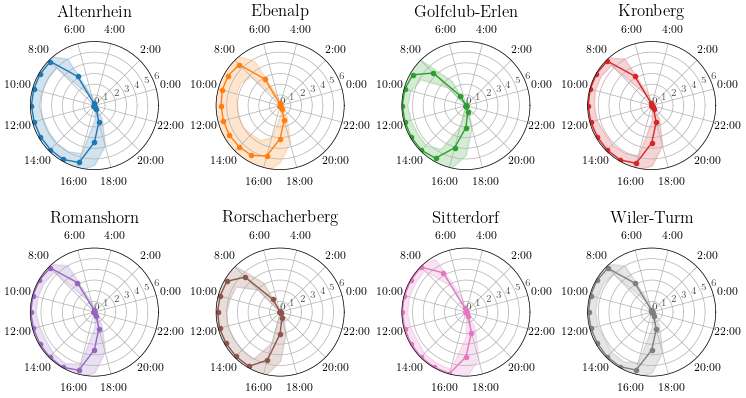

In [15]:
# Shift the angles by one tick to move the ticks to 3:00
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False)  # 24 hours
shift = 1 / 24  # Shift by 1 hour (1 out of 24 hours)
shifted_angles = np.roll(angles, -1)  # Shift the array to the left

# Define the hours for labeling
hours = list(range(24))  # 0 to 23

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(FIG_WIDTH, 4.2), subplot_kw={'projection': 'polar'})

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, (key, (mean_values, std_values)) in zip(axes, coverage_stats.items()):
    upper_bound = mean_values + std_values
    lower_bound = np.clip(mean_values - std_values, 0, None)  # Avoid negative values
    
    ax.plot(shifted_angles, mean_values, marker='o', label=key, color=wbc_cmap[key], markersize=3)  # Mean values
    ax.fill_between(shifted_angles, lower_bound, upper_bound, alpha=0.2, color=wbc_cmap[key])  # Shaded variance

    ax.set_xticks(shifted_angles[::2])  # Show ticks every 3 hours
    ax.set_xticklabels([f"{h}:00" for h in hours[::2]], fontsize=8)

    ax.set_ylim(0, 6)  # Ensure radial range is 0 to 6
    ax.set_yticks([0, 1, 2, 3, 4, 5, 6])  # Set radial tick marks
    ax.set_yticklabels(["0", "1", "2", "3", "4", "5", "6"], fontsize=7, alpha=0.7)  # Label the radial ticks
    ax.set_title(key.title())

# plt.suptitle("Coverage [img/h] of webcams per hour (Mean ± Variance)")
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/coverage-per-hour-polar.png", dpi=300)
